In [1]:
import kagglehub
feyzazkefe_trashnet_path = kagglehub.dataset_download('feyzazkefe/trashnet')

print('Data source import complete.')

Data source import complete.


In [2]:
import numpy as np
import pandas as pd


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/trashnet/dataset-resized/metal/metal375.jpg
/kaggle/input/trashnet/dataset-resized/metal/metal341.jpg
/kaggle/input/trashnet/dataset-resized/metal/metal374.jpg
/kaggle/input/trashnet/dataset-resized/metal/metal383.jpg
/kaggle/input/trashnet/dataset-resized/metal/metal215.jpg
/kaggle/input/trashnet/dataset-resized/metal/metal113.jpg
/kaggle/input/trashnet/dataset-resized/metal/metal213.jpg
/kaggle/input/trashnet/dataset-resized/metal/metal226.jpg
/kaggle/input/trashnet/dataset-resized/metal/metal147.jpg
/kaggle/input/trashnet/dataset-resized/metal/metal90.jpg
/kaggle/input/trashnet/dataset-resized/metal/metal130.jpg
/kaggle/input/trashnet/dataset-resized/metal/metal63.jpg
/kaggle/input/trashnet/dataset-resized/metal/metal149.jpg
/kaggle/input/trashnet/dataset-resized/metal/metal344.jpg
/kaggle/input/trashnet/dataset-resized/metal/metal8.jpg
/kaggle/input/trashnet/dataset-resized/metal/metal68.jpg
/kaggle/input/trashnet/dataset-resized/metal/metal323.jpg
/kaggle/input/trash

# **Importing Dependences**

In [3]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from collections import Counter


# **Defining the directory containing the dataset**

In [4]:
DATASET_DIR = '/kaggle/input/trashnet/dataset-resized/'

# **Defining image dimensions, batch size, and training parameters**


In [5]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
INITIAL_EPOCHS = 50
FINE_TUNE_EPOCHS = 20
NUM_CLASSES = 6


# **Configuring the data augmentation and preprocessing for the training set**


In [6]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    fill_mode='nearest'
)


# **Configuring the data augmentation and preprocessing for the validation set**


In [7]:
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)


### Creating data generators for training and validation


In [8]:
train_generator = train_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='categorical'
)


Found 2024 images belonging to 6 classes.


In [9]:
validation_generator = test_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical'
)


Found 503 images belonging to 6 classes.


# **Computing Class weights**

In [10]:
def compute_class_weights(generator):
    counter = Counter(generator.classes)
    max_count = float(max(counter.values()))
    class_weights = {cls: max_count / count for cls, count in counter.items()}
    return class_weights

class_names = list(train_generator.class_indices.keys())
print("Class names:", class_names)

class_weights = compute_class_weights(train_generator)
print("Class weights:", class_weights)


Class names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Class weights: {np.int32(0): 1.4736842105263157, np.int32(1): 1.1870324189526185, np.int32(2): 1.451219512195122, np.int32(3): 1.0, np.int32(4): 1.233160621761658, np.int32(5): 4.327272727272727}


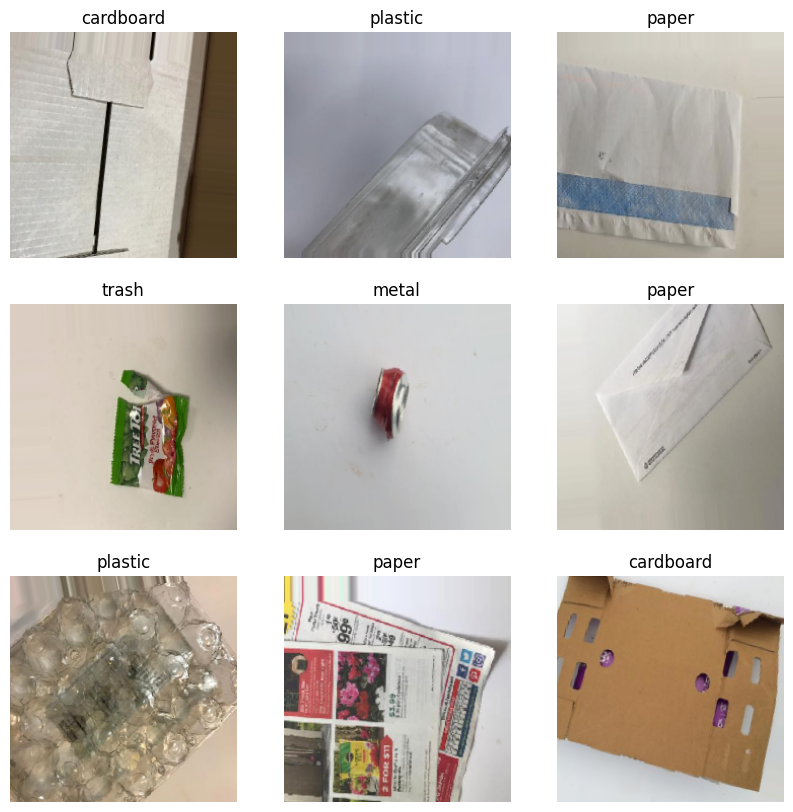

In [11]:
import matplotlib.pyplot as plt

images, labels = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(((images[i] + 1) / 2).astype('float32'))
    plt.title(class_names[tf.argmax(labels[i])])
    plt.axis('off')
plt.show()


# **Loading the pre-trained MobileNetV2 model**


In [12]:
base_model = MobileNetV2(weights='imagenet', include_top=False,
                         input_tensor=Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
base_model.trainable = False  # Freeze the base model initially


<ipython-input-12-c4b6942a139b>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False,


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Adding custom layers on top of the base model for classification


In [13]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)


In [14]:
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# **Creating callbacks**

In [15]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_model.keras", monitor='val_accuracy', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1)
]


# **Training the model with the initial training epochs**


In [16]:
history = model.fit(
    train_generator,
    epochs=INITIAL_EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    class_weight=class_weights,  # Using computed class weights
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2212 - loss: 3.3663
Epoch 1: val_accuracy improved from -inf to 0.44334, saving model to best_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.2221 - loss: 3.3624 - val_accuracy: 0.4433 - val_loss: 1.4533 - learning_rate: 1.0000e-04
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4452 - loss: 2.1959
Epoch 2: val_accuracy improved from 0.44334 to 0.57853, saving model to best_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.4457 - loss: 2.1944 - val_accuracy: 0.5785 - val_loss: 1.1272 - learning_rate: 1.0000e-04
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5408 - loss: 1.8430
Epoch 3: val_accuracy improved from 0.57853 to 0.62823, saving model to best_model.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.5411 - loss: 1.8417 - val_accuracy: 0.6282 - val_loss: 0.9783 - learning_rate: 1.0000e-04
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.630

# **Fine-tuning the model by unfreezing some layers and training for additional epochs**


In [17]:
for layer in base_model.layers[-30:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

In [18]:
model.compile(optimizer=Adam(learning_rate=5e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
total_epochs = INITIAL_EPOCHS + FINE_TUNE_EPOCHS
history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] + 1,
    validation_data=validation_generator,
    callbacks=callbacks,
    class_weight=class_weights,  # Using computed class weights
    verbose=1
)

Epoch 42/70
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8496 - loss: 0.5978
Epoch 42: val_accuracy did not improve from 0.79920
64/64 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - accuracy: 0.8496 - loss: 0.5978 - val_accuracy: 0.7734 - val_loss: 0.6342 - learning_rate: 5.0000e-05
Epoch 43/70
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8607 - loss: 0.5595
Epoch 43: val_accuracy did not improve from 0.79920
64/64 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.8607 - loss: 0.5594 - val_accuracy: 0.7475 - val_loss: 0.7017 - learning_rate: 5.0000e-05
Epoch 44/70
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8574 - loss: 0.5633
Epoch 44: val_accuracy did not improve from 0.79920
64/64 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.8576 - loss: 0.5628 - val_accuracy: 0.7594 - val_loss: 0.7356 - learning_rate: 5.0000e-05
Epoch 45/70
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8809 - loss: 0.4832
Epoch 45: val_accuracy did not improve from 0.79920
64/64 ━━━━━━━━━━━━━━━━━━

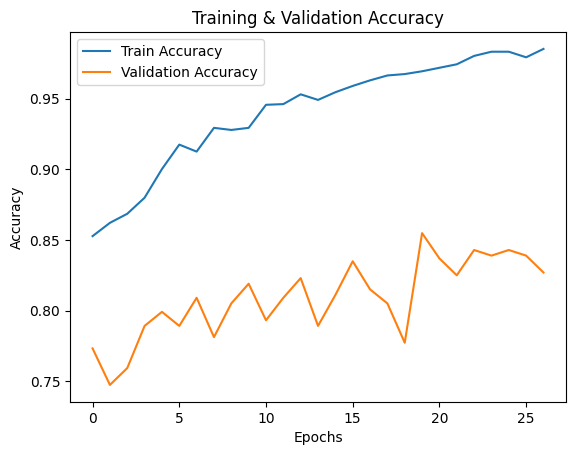

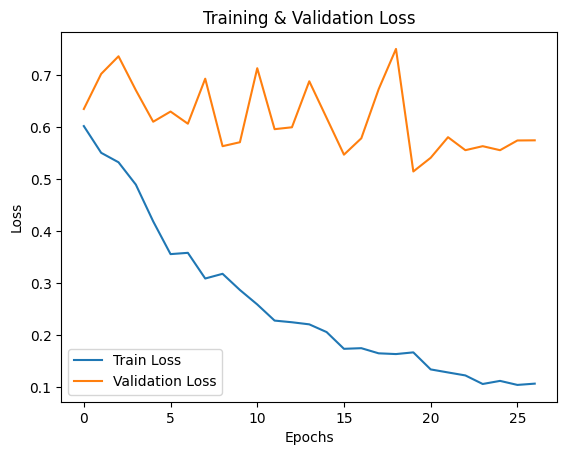

In [20]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.plot(history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')
plt.show()

# Plot training & validation loss
plt.plot(history_fine.history['loss'], label='Train Loss')
plt.plot(history_fine.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.show()